# Convolutional Neural Networks (CNN) Cont.

This notebook further covers Convolutional Neural Networks (CNN). In the last lab, we looked at the classic MNIST Digit classification problem using keras.

In this lab, we will work from a large database of images, containing dogs and cats, a more complicated classification task which requires advanced techniques.

Code and the information used in this notebook is taken from keras.io

Before running this notebook, switch your runtime to a GPU.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-06-05 20:29:53.341303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or 

### Step 1: Download  the data

We use the `curl` command to download the dataset.

This is a very large file. Make sure you have an active and good internet connection for this step.

In [2]:
! curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  21.6M      0  0:00:36  0:00:36 --:--:-- 18.2M


In [3]:
! ls

05-exemplar_hw5.pdf
1-2-3building_blocks_actiivity_solution (1).ipynb
1-2-3building_blocks_actiivity_solution.ipynb
1-300x169.png
2-4-1readingfiles.ipynb
202112_Wage and Income_ALDE_102588677340.pdf
26801_dats_2.2.json
26801_ddi_2.5.xml
26801_oai_pmh.xml
4-4-1readingdata.ipynb
4ada6330-f702-4a8b-8b62-1ac75c270834 (1).pdf
4ada6330-f702-4a8b-8b62-1ac75c270834.pdf
4cf3365e-0f5f-4f32-b37c-e32dc072fd73.html
4cf3365e-0f5f-4f32-b37c-e32dc072fd73.pdf
7-3-2mongodbdemo.ipynb
72bdbf99-da81-4890-8ccd-76c37e3d8d20 (1).pdf
72bdbf99-da81-4890-8ccd-76c37e3d8d20.pdf
8-1-2db-from-file.ipynb
8-1-3_tweets_activity_review.ipynb
8-3-1snscrapeexample.ipynb
8-4-2facebookscraping.ipynb
AWS_Lab1.doc
AWS_Lab1.pdf
Academic Transcript Alderfer.pdf
Alderfer DLP-Lab-00-Matplotlib-1 (1).ipynb
Alderfer DLP-Lab-00-Matplotlib-1.ipynb
Alderfer DLP-Lab-01-Machine-Learning-1 (1).ipynb
Alderfer DLP-Lab-01-Machine-Learning-1.ipynb
Alderfer DLP-Lab-02-Feed-Forward-Networks-1.ipynb
Alderfer DLP-Lab-03-Fully-Connected-Networks-

Unzip the file downloaded in the previous step.

In [4]:
! unzip -q kagglecatsanddogs_5340.zip

In [5]:
! ls PetImages

Cat Dog


### Removing any corrupted files

In [6]:
import os

num_skipped = 0
for folder_name in ('Cat', 'Dog'):
    folder_path = os.path.join('PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, 'rb')
            is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


### Step 2:  Loading data from directory

In this step, we will learn how to load an image set from a directory. We will also create two sets of randomly selected images for our training and validation.

We will use a function from `keras.preprocessing` which will return a object of type `tf.data.Dataset`.

The `image_dataset_from_directory` function takes few arguments such as folder name, validation_split and batch size, and creates dataset. The arguments we have used are explained below.

- `directory`: name of the directory from which images are to be imported.
- `validation_split`: it specifies the fraction of data used for validation set.
- `subset`: we can select either 'training' or 'validation' and it will create the dataset respectively.
- `image_size`: size used to resize images after reading from disk.
- `batch_size`: size of batches. Default is 32.

Note: There are various ways to load data from a directory.

In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'PetImages',
    validation_split = 0.2,
    subset = 'training',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'PetImages',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


### Visualizing the data

THe code below makes a 3x3 grid and builds a visualization of the first 9 images from the dataset. Each image is annotated with its class.

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


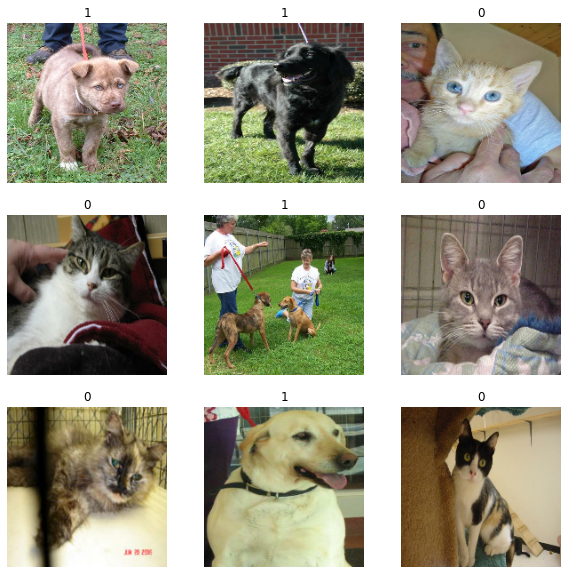

In [8]:
import matplotlib.pyplot as plt

# specifying the size of the plot
plt.figure(figsize = (10, 10))

# outer for loop to select images and labels from dataset
# train_ds.take(1) selects the first batch of 32 images
for images, labels in train_ds.take(1):

    # inner for loop for visualizing images in grid
    for i in range(9):

        # specifying the subplot parameters and the place to display
        # first two parameters are used for rows and columns
        ax = plt.subplot(3, 3, i + 1)
        # plt.imshow is a function from matplotlib used for showing image as plots
        plt.imshow(images[i].numpy().astype('uint8'))
        # priting class of image as title
        plt.title(int(labels[i]))
        # turning off the axis
        plt.axis('off')

### Step 3: Data Augmentation

Excerpt from Deep Learning with Python, Second Edition, by François Chollet:

> Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data so it can generalize better.

In [9]:
# here, we create a sequential layer with two preprocessing layers for data augmentation
data_augmentation = keras.Sequential(
    [
        # randomly flip each image horizontally
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomFlip('vertical'),

        # randomly rotate image as a fraction of 2pi (0.1 * 2pi)
        layers.experimental.preprocessing.RandomRotation((0.1,0.8)),
        layers.experimental.preprocessing.RandomContrast(0.05)
    ]
)

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


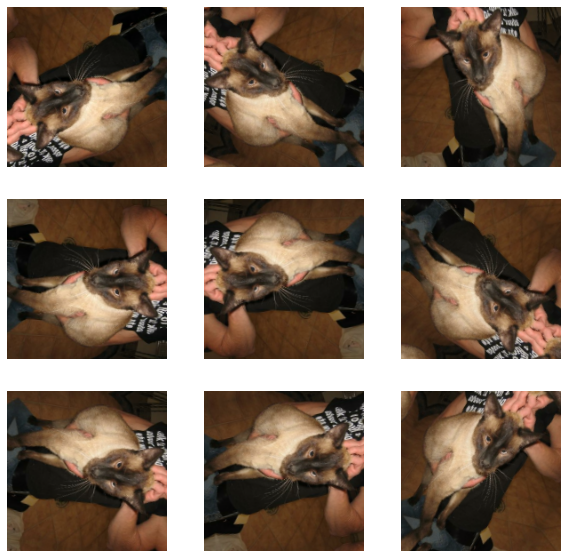

In [10]:
# plotting augmentated image
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [11]:
# mapping the augmentated image into train set
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y))

In the next step, we will set up a process to pre-fetch training and validation data. By prefetching the data, the training and validation loops can fetch the next batch from memory while the model is still processing the current batch, ensuring a steady stream of data and reducing potential bottlenecks caused by data loading delays.

In [12]:
# pre-fetching training and validation data
train_ds = train_ds.prefetch(buffer_size = 32)
val_ds = val_ds.prefetch(buffer_size = 32)

In [16]:
pip install pydot

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install graphviz

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pydot
import graphviz

### Step 4: Building the Model

In [22]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # image augmentation block
    x = data_augmentation(inputs)

    # entry block
    x = layers.Conv2D(32, (3,3), strides = 2, padding = 'same')(x)
    x = layers.MaxPooling2D(2, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding = 'same')(x)
    x = layers.MaxPooling2D(3,padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

   
    x = layers.SeparableConv2D(128, 3, padding='same')(x)
    x = layers.MaxPooling2D(2,padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(64, 3, padding = 'same')(x)
    x = layers.MaxPooling2D(2,padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(32, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation = 'softmax')(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes = 2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
epochs = 5

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)
model.fit(
    train_ds, epochs = epochs, validation_data = val_ds,
)

Epoch 1/5


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


292/586 [=============>................] - ETA: 2:29 - loss: 0.6256 - accuracy: 0.4955

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 2:13 - loss: 0.6219 - accuracy: 0.4976

401/586 [===================>..........] - ETA: 1:34 - loss: 0.6128 - accuracy: 0.4994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


410/586 [===================>..........] - ETA: 1:29 - loss: 0.6116 - accuracy: 0.4979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


422/586 [====================>.........] - ETA: 1:23 - loss: 0.6104 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


429/586 [====================>.........] - ETA: 1:19 - loss: 0.6096 - accuracy: 0.4974

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.4970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 328s 549ms/step - loss: 0.5974 - accuracy: 0.4970 - val_loss: 0.6416 - val_accuracy: 0.5043
Epoch 2/5


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


292/586 [=============>................] - ETA: 2:32 - loss: 0.5500 - accuracy: 0.4957

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 2:15 - loss: 0.5475 - accuracy: 0.4979

401/586 [===================>..........] - ETA: 1:35 - loss: 0.5440 - accuracy: 0.4984

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


410/586 [===================>..........] - ETA: 1:30 - loss: 0.5438 - accuracy: 0.4980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


422/586 [====================>.........] - ETA: 1:24 - loss: 0.5431 - accuracy: 0.4983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


429/586 [====================>.........] - ETA: 1:20 - loss: 0.5424 - accuracy: 0.4973

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.4970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 321s 548ms/step - loss: 0.5366 - accuracy: 0.4970 - val_loss: 0.6388 - val_accuracy: 0.5043
Epoch 3/5


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


292/586 [=============>................] - ETA: 2:28 - loss: 0.5006 - accuracy: 0.4954

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 2:12 - loss: 0.4999 - accuracy: 0.4985

401/586 [===================>..........] - ETA: 1:33 - loss: 0.4989 - accuracy: 0.4977

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


410/586 [===================>..........] - ETA: 1:28 - loss: 0.4985 - accuracy: 0.4989

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


422/586 [====================>.........] - ETA: 1:22 - loss: 0.4981 - accuracy: 0.4984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


429/586 [====================>.........] - ETA: 1:18 - loss: 0.4986 - accuracy: 0.4972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.4970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 314s 535ms/step - loss: 0.4939 - accuracy: 0.4970 - val_loss: 0.6409 - val_accuracy: 0.5043
Epoch 4/5


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


292/586 [=============>................] - ETA: 2:24 - loss: 0.4799 - accuracy: 0.4955

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 2:09 - loss: 0.4802 - accuracy: 0.4985

401/586 [===================>..........] - ETA: 1:31 - loss: 0.4808 - accuracy: 0.4981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


410/586 [===================>..........] - ETA: 1:26 - loss: 0.4803 - accuracy: 0.4984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


422/586 [====================>.........] - ETA: 1:20 - loss: 0.4789 - accuracy: 0.4977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


429/586 [====================>.........] - ETA: 1:17 - loss: 0.4782 - accuracy: 0.4975

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.4970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 308s 525ms/step - loss: 0.4745 - accuracy: 0.4970 - val_loss: 0.5651 - val_accuracy: 0.5043
Epoch 5/5


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


292/586 [=============>................] - ETA: 2:22 - loss: 0.4603 - accuracy: 0.4948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 2:07 - loss: 0.4588 - accuracy: 0.4986

401/586 [===================>..........] - ETA: 1:34 - loss: 0.4584 - accuracy: 0.4981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


410/586 [===================>..........] - ETA: 1:30 - loss: 0.4578 - accuracy: 0.4980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


422/586 [====================>.........] - ETA: 1:25 - loss: 0.4580 - accuracy: 0.4983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


429/586 [====================>.........] - ETA: 1:23 - loss: 0.4568 - accuracy: 0.4978

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.4970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 374s 637ms/step - loss: 0.4567 - accuracy: 0.4970 - val_loss: 0.5079 - val_accuracy: 0.5043
